# Import Library

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import string
import json
import emoji

import nltk
nltk.download('punkt_tab')

from scipy.stats import randint, uniform, loguniform
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/atmatech/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Load Dataset

In [ ]:
dataset = pd.read_csv("dataset_tweet_sentiment_cellular_service_provider.csv")
dataset

,Id,Sentiment,Text Tweet
0,1,positive,<USER_MENTION> #BOIKOT_<PROVIDER_NAME> Gunakan Produk Bangsa Sendiri <PROVIDER_NAME>
1,2,positive,"Saktinya balik lagi, alhamdulillah :v <PROVIDER_NAME>"
2,3,negative,Selamat pagi <PROVIDER_NAME> bisa bantu kenapa di dalam kamar sinyal 4G hilang yang 1 lagi panggilan darurat saja <URL>
3,4,negative,Dear <PROVIDER_NAME> akhir2 ini jaringan data lemot banget padahal H+ !!!!
4,5,negative,Selamat malam PENDUSTA <PROVIDER_NAME>
...,...,...,...
295,296,positive,"Pantesan lancar ya, sinyal <PROVIDER_NAME> yang 4G lancar sekali di lombok timur"
296,297,positive,Alhamdulillah lancar pakai <PROVIDER_NAME>
297,298,positive,"Untung pakai internet <PROVIDER_NAME>, lancar, jadi dapat banyak ide."
298,299,positive,"di tempat ramai seperti di lokasi wisata, <PROVIDER_NAME> tetap jaya."


# Overview Data

In [17]:
# Jumlah baris dan kolom
print('Jumlah Baris      :', dataset.shape[0])
print('Jumlah Kolom      :', dataset.shape[1])

# Kolom 'Sentiment' adalah Label dan Kolom 'Text Tweet adalah Fitur'
fitur = ['Text Tweet']
target = 'Sentiment'

# Informasi jumlah kolom fitur dan label
print(f'Terdapat {len(fitur)} Kolom Fitur dan 1 Kolom Target ({target}) pada Dataset')
print('Fitur Data           :', fitur)
print('Target/Label Data    :', ['Sentiment'])
print('Jumlah Label Unik    :', dataset['Sentiment'].nunique())
print('Unique Labels        :', dataset['Sentiment'].unique().tolist())

# Tampilkan 5 baris pertama
pd.options.display.max_columns = None
dataset.head()


Jumlah Baris      : 300
Jumlah Kolom      : 3
Terdapat 1 Kolom Fitur dan 1 Kolom Target (Sentiment) pada Dataset
Fitur Data           : ['Text Tweet']
Target/Label Data    : ['Sentiment']
Jumlah Label Unik    : 2
Unique Labels        : ['positive', 'negative']


,Id,Sentiment,Text Tweet
0,1,positive,<USER_MENTION> #BOIKOT_<PROVIDER_NAME> Gunakan Produk Bangsa Sendiri <PROVIDER_NAME>
1,2,positive,"Saktinya balik lagi, alhamdulillah :v <PROVIDER_NAME>"
2,3,negative,Selamat pagi <PROVIDER_NAME> bisa bantu kenapa di dalam kamar sinyal 4G hilang yang 1 lagi panggilan darurat saja <URL>
3,4,negative,Dear <PROVIDER_NAME> akhir2 ini jaringan data lemot banget padahal H+ !!!!
4,5,negative,Selamat malam PENDUSTA <PROVIDER_NAME>


Data terdiri dari 300 baris data dengan 2 kolom yaotu kolom fitur "Text Tweet" dan kolom target/label "Sentiment", dengan label unik hanya ada 2 yaitu sentimen "positive" dan "negative"

In [18]:
# Cek Tipe Dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Id          300 non-null    int64 
 1   Sentiment   300 non-null    object
 2   Text Tweet  300 non-null    object
dtypes: int64(1), object(2)
memory usage: 7.2+ KB


Jadikan kolom 'Id' (Number Identifier) sebagai index dataframe

In [19]:
# Jadikan kolom 'Id' sebagai index
dataset = dataset.set_index('Id')
dataset

,Sentiment,Text Tweet
Id,,
1,positive,<USER_MENTION> #BOIKOT_<PROVIDER_NAME> Gunakan Produk Bangsa Sendiri <PROVIDER_NAME>
2,positive,"Saktinya balik lagi, alhamdulillah :v <PROVIDER_NAME>"
3,negative,Selamat pagi <PROVIDER_NAME> bisa bantu kenapa di dalam kamar sinyal 4G hilang yang 1 lagi panggilan darurat saja <URL>
4,negative,Dear <PROVIDER_NAME> akhir2 ini jaringan data lemot banget padahal H+ !!!!
5,negative,Selamat malam PENDUSTA <PROVIDER_NAME>
...,...,...
296,positive,"Pantesan lancar ya, sinyal <PROVIDER_NAME> yang 4G lancar sekali di lombok timur"
297,positive,Alhamdulillah lancar pakai <PROVIDER_NAME>
298,positive,"Untung pakai internet <PROVIDER_NAME>, lancar, jadi dapat banyak ide."


## Cek Missing Values

In [20]:
# Cek Missing Value
dataset.isna().sum()

Sentiment     0
Text Tweet    0
dtype: int64

Pada dataset tidak terdapat "Missing Value"

## Statistik Deskriptif Dataset

In [21]:
# Statistik Deskriptif Dataset
dataset.describe(include=['object'])

,Sentiment,Text Tweet
count,300,300
unique,2,298
top,negative,Terimakasih ya <PROVIDER_NAME> gratis 4Gnya ayo buruan upgrade <PRODUCT_NAME>
freq,161,2


Pada kolom label "Sentiment" hanya memiliki 2 label dengan total data sebanyak 300 baris tanpa ada "Missing Value" dengan label yang paling banyak adalah "negative" dengan 161 data. Sedangkan pada kolom fitur "Text Tweet" teridiri dari 300 data tanpa "Missing Value" dan 298 data di antaranya unik, perlu peninjauan untuk mengidentifikasi apakah ada data duplikat pada kolom "Text Tweet".

## Cek Data Duplikat

In [22]:
# Cek Data Duplikat
duplicate = dataset.duplicated(subset='Text Tweet', keep=False)
duplicate = dataset[duplicate]
duplicate

,Sentiment,Text Tweet
Id,,
27,negative,Jaringan internet <PROVIDER_NAME> di sumba timur parah....
117,positive,Terimakasih ya <PROVIDER_NAME> gratis 4Gnya ayo buruan upgrade <PRODUCT_NAME>
172,positive,Terimakasih ya <PROVIDER_NAME> gratis 4Gnya ayo buruan upgrade <PRODUCT_NAME>
254,negative,Jaringan internet <PROVIDER_NAME> di sumba timur parah....


Terdapat dua data "Text Tweet" yang duplikat, langkah selanjutnya adalah menghapus data tersebut.

In [23]:
# Hapus Data Duplikat
dataset = dataset.drop_duplicates(subset='Text Tweet', keep='first').reset_index(drop=True)
duplicate = dataset.duplicated(subset='Text Tweet', keep=False)
duplicate = dataset[duplicate]
print(f"Jumlah duplikat pada kolom 'Text Tweet' setelah dihapus: {duplicate.shape[0]}")
dataset.head(5)

Jumlah duplikat pada kolom 'Text Tweet' setelah dihapus: 0


,Sentiment,Text Tweet
0,positive,<USER_MENTION> #BOIKOT_<PROVIDER_NAME> Gunakan Produk Bangsa Sendiri <PROVIDER_NAME>
1,positive,"Saktinya balik lagi, alhamdulillah :v <PROVIDER_NAME>"
2,negative,Selamat pagi <PROVIDER_NAME> bisa bantu kenapa di dalam kamar sinyal 4G hilang yang 1 lagi panggilan darurat saja <URL>
3,negative,Dear <PROVIDER_NAME> akhir2 ini jaringan data lemot banget padahal H+ !!!!
4,negative,Selamat malam PENDUSTA <PROVIDER_NAME>


## Jumlah persebaran data berdasarkan label "Sentiment"

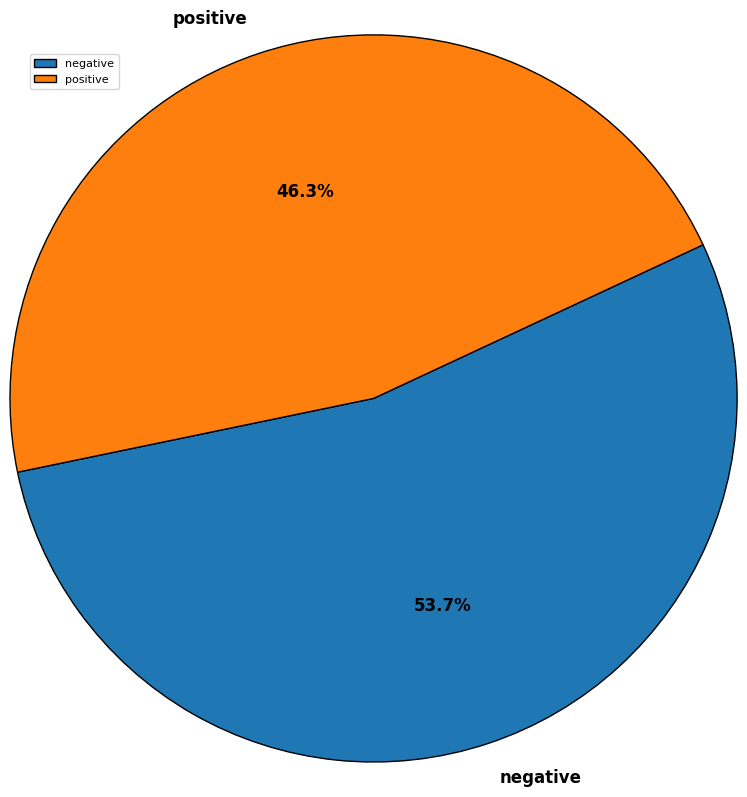

Jumlah Data Sentimen 'negative': 160
Jumlah Data Sentimen 'positive': 138


In [24]:
#Jumlah Persebaran Data
sentiment_counts = dataset['Sentiment'].value_counts()
labels = sentiment_counts.index.tolist()
sizes = sentiment_counts.values

# Pie Plot Persentase Persebaran Data Sentiment
plt.rcParams["figure.figsize"] = (15, 8)
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    wedgeprops={'edgecolor': 'black'},
    counterclock=False,
    startangle=25,
    radius=1.3,
    textprops={'fontsize': 12, 'weight': 'bold'}
)
plt.legend(labels, loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

# Jumlah Persebaran Data Sentiment setiap Label
for label, count in sentiment_counts.items():
    print(f"Jumlah Data Sentimen '{label}': {count}")

Berdasarkan jumlah persebaran data sentiment didapatkan selisih antar dua kelas "positive" dan "negative" sekitar 7.4% distribusi ini masih relatif seimbang (balanced) sehingga belum perlu dilakukan perlakuan khusus.

## Wordcloud & Bar Plot (Frekuensi Kata)

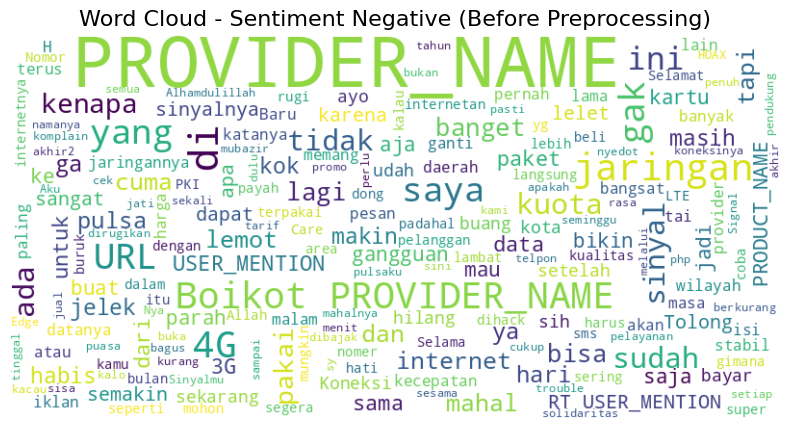

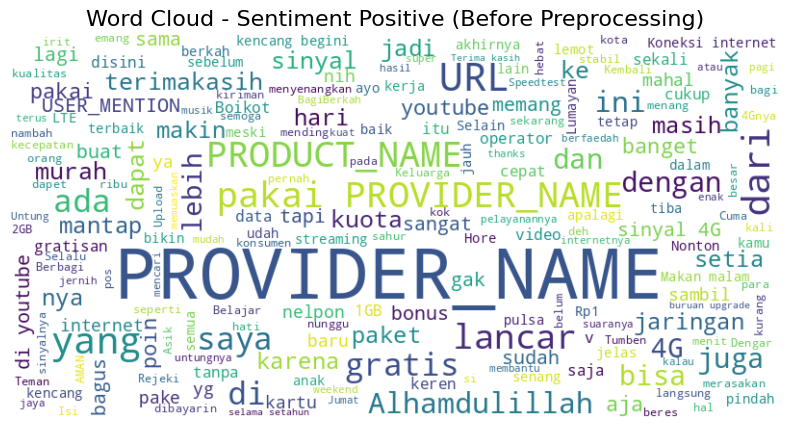

In [25]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# WordCloud untuk sentimen negatif
negatif_text = dataset[dataset["Sentiment"] == 'negative']["Text Tweet"]
text_negatif_joined = " ".join(negatif_text)
wordcloud_negatif = WordCloud(width=800, height=400, background_color='white').generate(text_negatif_joined)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negatif, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Sentiment Negative (Before Preprocessing)", fontsize=16)
plt.show()

# WordCloud untuk sentimen positif
positif_text = dataset[dataset["Sentiment"] == 'positive']["Text Tweet"]
text_positif_joined = " ".join(positif_text)
wordcloud_positif = WordCloud(width=800, height=400, background_color='white').generate(text_positif_joined)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positif, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Sentiment Positive (Before Preprocessing)", fontsize=16)
plt.show()

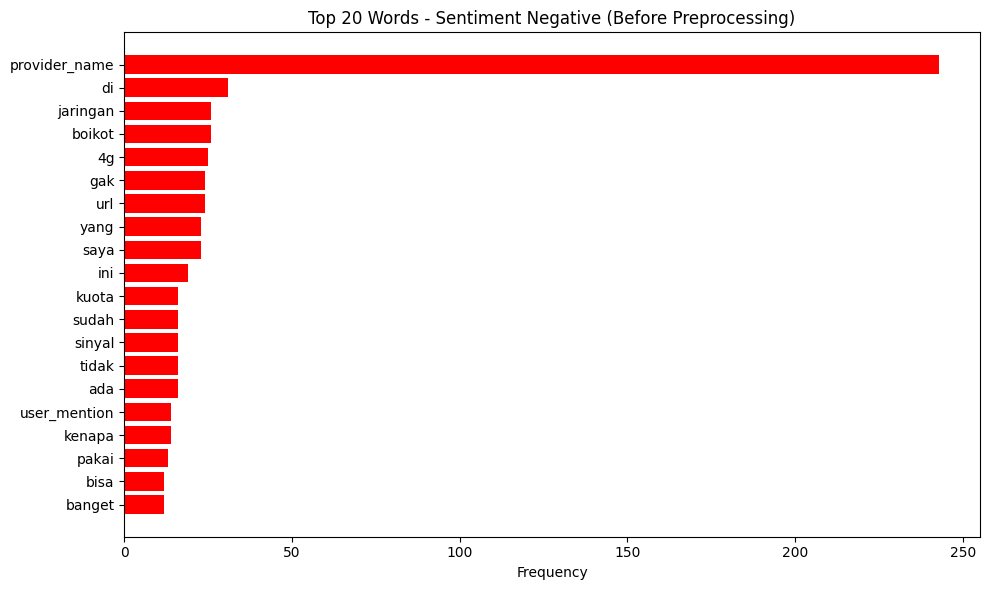

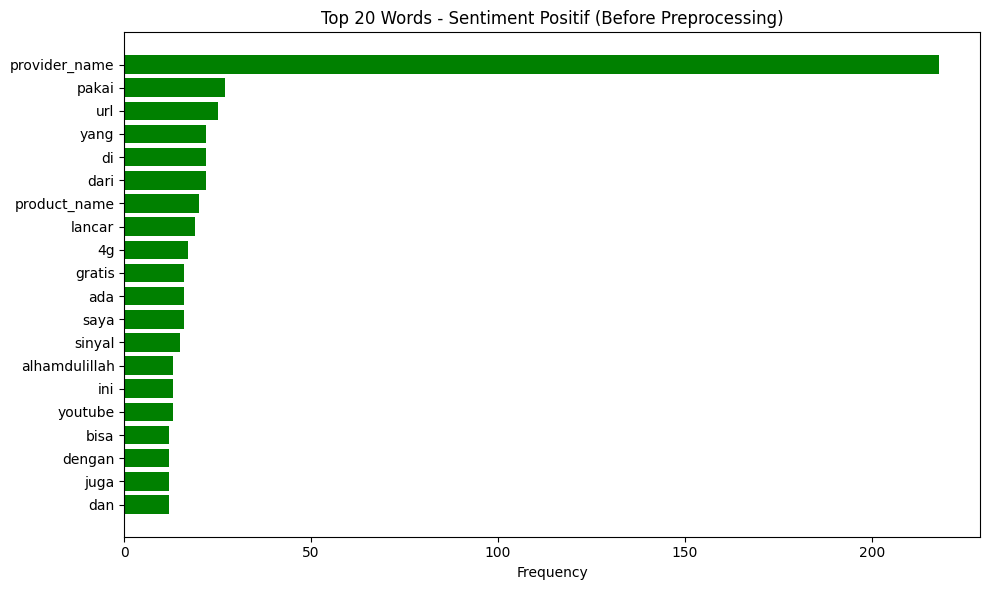

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import matplotlib.pyplot as plt

# Fungsi untuk plot bar kata teratas
def plot_top_words(text_series, title, color='skyblue'):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(text_series)
    word_counts = X.sum(axis=0).A1
    vocab = vectorizer.get_feature_names_out()
    
    freq_df = pd.DataFrame({'word': vocab, 'count': word_counts})
    top_words = freq_df.sort_values(by='count', ascending=False).head(20)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(top_words['word'][::-1], top_words['count'][::-1], color=color)
    plt.xlabel("Frequency")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Plot untuk sentimen negatif
negatif_text = dataset[dataset["Sentiment"] == 'negative']["Text Tweet"]
plot_top_words(negatif_text, "Top 20 Words - Sentiment Negative (Before Preprocessing)", color='red')

# Plot untuk sentimen positif)
positif_text = dataset[dataset["Sentiment"] == 'positive']["Text Tweet"]
plot_top_words(positif_text, "Top 20 Words - Sentiment Positif (Before Preprocessing)", color='green')


Temuan berdasarkan hasil visualisasi frekuensi kata (wordcloud & barplot), ditemukan bahwa entitas seperti PROVIDER_NAME, USER_MENTION, PRODUCT_NAME, dan URL sering muncul pada data "Text Tweet" dan persebarannya merata baik pada sentimen negative maupun positive. Oleh karena itu, keberadaan kata-kata tersebut perlu ditinjau lebih lanjut karena tidak memberikan kontribusi signifikan dalam membedakan antara sentimen negative dan postive. Selain itu juga pada hasil visualisasi dapat dilihat masih banyak kata-kata yang termasuk `stopwords` oleh karena itu perlu dihilangkan agar lebih optimal dalam proses analisa sentimennya.

# Preprocessing Data

In [27]:
pd.set_option("display.max_colwidth", 200)
dataset.head(30)

,Sentiment,Text Tweet
0,positive,<USER_MENTION> #BOIKOT_<PROVIDER_NAME> Gunakan Produk Bangsa Sendiri <PROVIDER_NAME>
1,positive,"Saktinya balik lagi, alhamdulillah :v <PROVIDER_NAME>"
2,negative,Selamat pagi <PROVIDER_NAME> bisa bantu kenapa di dalam kamar sinyal 4G hilang yang 1 lagi panggilan darurat saja <URL>
3,negative,Dear <PROVIDER_NAME> akhir2 ini jaringan data lemot banget padahal H+ !!!!
4,negative,Selamat malam PENDUSTA <PROVIDER_NAME>
5,negative,Untuk penembakan paket dari <PRODUCT_NAME> masih gangguan ya <PROVIDER_NAME>
6,positive,"<PROVIDER_NAME> aku pakai <PROVIDER_NAME>, paket <PRODUCT_NAME> nya udah off tapi gantinya ada paket <PRODUCT_NAME> yg bisa gratisan youtube, senang banget <PROVIDER_NAME>"
7,negative,RT <USER_MENTION>: <PROVIDER_NAME> tak ada lagi dalam kamus perhapean saya. #Boikot<PROVIDER_NAME> <URL>
8,negative,keluhan gak ditanggapi. bikin emosi aja. pulsaku dicuri terus. soak deh. masa setiap hari pulsa berkurang 1500-2100 bisa 2-3*/hari
9,negative,#Bilboard iklan <PROVIDER_NAME> kok ada pesan tersembunyi? #Boikot<PROVIDER_NAME> #Ramadhan <URL>


Sebelum menyusun preprocessing perlu meninjau secara keseluruhan "Text Tweet", berikut beberapa poin yang didapat:

1. Penghapusan Entitas Bertanda Khusus (<...>)

    Berdasarkan temuan yang didapat setelah melakukan visualisasi frekuensi kata pada "Text Tweet" didapatkan bahwa perlu nya menghapus entitas `special token` yang diformatkan dalam tanda baca "<>" seperti `<PROVIDER_NAME>`, `<USER_MENTION>`, , `<PRODUCT_NAME>`, `<URL>`. Karena entitas ini paling sering muncul baik pada sentimen negative dan positive.

2. Ekstraksi Entitas dari Hashtag (#)

    Entitas Hashtag `#` pada "Tweet Text" perlu dimasukkan ke dalam proses training model karena sering mengandung konteks penting atau opini pengguna, entitas tersebut memiliki potensi sebagai fitur penting. Oleh karena itu perlu dilakukan `hashtag removal` dengan menghapus simbol `#` namun entitas nya tetap digunakan. Contoh #Boikot `→` Boikot.

3. Standar Preprocessing Teks (Pembersihan Teks)

    Guna memastikan konsistensi dan kualitas data, teks pada "Text Tweet" perlu dibersihkan dengan cara: 
    
        a. Hapus tautan (link).
        b. Hapus mention(@username).
        c. Hapus tag RT (retweet).
        d. Hapus tanda baca (punctuation).
        e. Mengubah karakter newline menjadi spasi. 
        f. Hapus spasi ekstra pada awal dan akhir teks.
    
    Tujuannya untuk menyederhanakan teks sehingga lebih relevan.

4. Case Folding

    Mengubah setiap karakter kata menjadi huruf kecil (lowercase) agar semuanya konsisten.

5. Tokenisasi

    Mengubah teks menjadi list tokens digunakan dalam proses lanjutan seperti normalisasi teks informal ke formal dan stopwords karena prosesnya dalam tingkat tokens. Contoh: "Paket extra combo kok lemot" `→` ['Paket', 'extra', 'combo', 'kok', 'lemot']

6. Normalisasi Teks Informal ke Bentuk Formal 

    Oleh karena data "Text Tweet" berasal dari media sosial X/Twitter, banyak ditemukan bahasa sehari-hari yang tidak baku/slang dan singkatan. Oleh karena itu perlu dilakukan normalisasi `informal_to_formal` dengan mengubah kata-kata slang menjadi kata baku agar lebih konsisten dan dapat diproses dengan baik oleh model. Perubahan ini memanfaatkan *dictionary* atau kamus bahasa slang yang dimiliki. Contoh: "lemot" `→` lamban | "gak" `→` "tidak".

7. Penghapusan Stopwords dengan Penyesuaian 

    Berdasarkan hasil visualisasi frekuensi kata, banyak ditemukan kata-kata yang termasuk stopwords atau kata-kata umum yang mungkin tidak memiliki konteks penting dalam analisa sentimen. Oleh karena itu perlu dilakukan filtering `stopwords removal` dengan memanfaatkan library
    `StopWordRemoverFactory Sastrawi`. Tetapi perlu diperhatikan beberapa kata yang termasuk stopwords pada library tersebut tetap dipertahankan karena berperan penting dalam menentukan analisa sentimen terutama pada jenis kata negasi dan ungkapan seperti ['bisa', 'tidak', 'lebih', 'baik', 'buruk', 'suka', 'benci', 'cinta', 'senang', 'marah', 'kesal', 'bagus', 'jelek'] bebeapa kata ini tidak disertakan ke dalam daftar stopwords. 
    
    Contoh Kasus perlunya penyesuaian stopwords, tinjau dataset pada indeks (Id) ke-97:

    `"Text Tweet" : "lebih baik <PROVIDER_NAME>"`

    Jika tanpa penyesuaian stopwords, maka:

    - Kata "lebih" dan "baik" akan dihapus (karena termasuk daftar stopwords library),
    - Entitas <PROVIDER_NAME> juga akan dihapus (karena termaasuk special token),

    Hasil akhirnya adalah kalimat kosong, sehingga informasi sentimen hilang. Oleh karena itu, penting untuk mengecualikan kata-kata bermakna sentimen dari daftar stopwords bawaan library.

8. Detokenisasi 

    Menggabungkan kembali list token hasil preprocessing ke teks utuh kembali

9. Stemming untuk Menyederhanakan Kata 

    Setelah mendapatkan kata-kata kunci dari hasil `stopwords removal`, selanjutnya adalah dilakukan proses `stemming` yaitu dengan mengubah kata ke bentuk dasarnya. Gunanya adalah mengurangi kompleksitas kosakata dan lebih representatif. Contoh: "Mengecewakan" `→` "kecewa".

In [ ]:
# Load informal-to-formal dictionary
with open("informal_to_formal.json") as json_file:
    dictionaries = json.load(json_file)

# Load Sastrawi stopwords and customize
factory = StopWordRemoverFactory()
stopwords = factory.get_stop_words()
important_words = {'bisa', 'tidak', 'lebih', 'baik', 'buruk', 'suka', 'benci', 'cinta', 'senang', 'marah', 'kesal', 'bagus', 'jelek'}
stopwords = [word for word in stopwords if word not in important_words]

# Inisialisasi stemmer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()

def cleansing(text):
    # 1. Hapus special tokens
    def strip_special_tokens(text):
        return re.sub(r'<[^<>]+>', '', text)
    
    # 2. Hapus simbol (#) tetap mempertahankan kata setelahnya
    def strip_hashtags(text):
        return re.sub(r"#(\w+)", r"\1", text)
    
    # 3.a  Hapus tautan (link)
    def strip_links(text):
        return re.sub(r'http\S+', '', text)
    
    # 3.b Hapus mention (@username)
    def strip_mention(text):
        return re.sub(r'@[A-Za-z0-9_]+', '', text)
    
    # 3.c Hapus tag RT (retweet)
    def strip_retweet(text):
        return re.sub(r'\bRT\b[\s]*', '', text)
    
    # 3.d Hapus tanda baca (punctuation)
    def strip_punctuation(text):
        return re.sub(r'[^\w\s]', ' ', text)
    
    # 3.e Mengubah karakter newline menadi spasi.
    def strip_newline(text):
        return text.replace('\n', ' ')

    # 4. Mengubah karakter kata menjadi huruf kecil (lowercase)
    def case_folding(text):
        return text.lower()
    
    # 5. Mengubah teks menjadi list token
    def tokenizer(text):
        return nltk.word_tokenize(text)
    
    # 6. Normalisasi kata informal/slang ke formal berdasarkan kamus slang (dictionaries)
    def informal_to_formal(tokens):
        return [dictionaries.get(word, word).lower() for word in tokens]

    # 7. Hapus stopwords dengan penyesuaian kustomisasi daftar stopwords
    def remove_stopwords(tokens):
        return [word for word in tokens if word not in stopwords and word != '']
    
    # 8. Menggabungkan kembali list token menjadi teks utuh
    def detokenizer(tokens):
        return ' '.join(tokens)
    
    # 9. Stemming untuk mengubah kata ke bentuk dasarnya
    def stemming(text):
        return stemmer.stem(text)
    
    # Cleaning (Text Level)
    text = strip_special_tokens(text)
    text = strip_hashtags(text)
    text = strip_links(text)
    text = strip_mention(text)
    text = strip_retweet(text)
    text = strip_punctuation(text)
    text = strip_newline(text)
    text = case_folding(text)
    
    # Tokenisasi
    tokens = tokenizer(text)

    # Transformasi (Token Level)
    tokens = informal_to_formal(tokens)   
    tokens = remove_stopwords(tokens) 
    
    # Detokenisasi
    text = detokenizer(tokens)

    # Transformasi (Text Level)
    text = stemmer.stem(text)

    return text.strip() # Hapus spasi ekstra pada awal dan akhir teks.


In [29]:
# Terapkan preprocessing function ke dataset 
dataset['text_clean'] = dataset['Text Tweet'].apply(cleansing)
dataset

,Sentiment,Text Tweet,text_clean
0,positive,<USER_MENTION> #BOIKOT_<PROVIDER_NAME> Gunakan Produk Bangsa Sendiri <PROVIDER_NAME>,boikot guna produk bangsa sendiri
1,positive,"Saktinya balik lagi, alhamdulillah :v <PROVIDER_NAME>",sakti balik sedang alhamdulillah v
2,negative,Selamat pagi <PROVIDER_NAME> bisa bantu kenapa di dalam kamar sinyal 4G hilang yang 1 lagi panggilan darurat saja <URL>,selamat pagi bisa bantu kamar sinyal 4g hilang 1 sedang panggil darurat
3,negative,Dear <PROVIDER_NAME> akhir2 ini jaringan data lemot banget padahal H+ !!!!,dear akhir2 jaring data lamban sangat padahal h
4,negative,Selamat malam PENDUSTA <PROVIDER_NAME>,selamat malam dusta
...,...,...,...
293,positive,"Pantesan lancar ya, sinyal <PROVIDER_NAME> yang 4G lancar sekali di lombok timur",pantas lancar sinyal 4g lancar sekali lombok timur
294,positive,Alhamdulillah lancar pakai <PROVIDER_NAME>,alhamdulillah lancar pakai
295,positive,"Untung pakai internet <PROVIDER_NAME>, lancar, jadi dapat banyak ide.",untung pakai internet lancar jadi banyak ide
296,positive,"di tempat ramai seperti di lokasi wisata, <PROVIDER_NAME> tetap jaya.",tempat ramai lokasi wisata tetap jaya


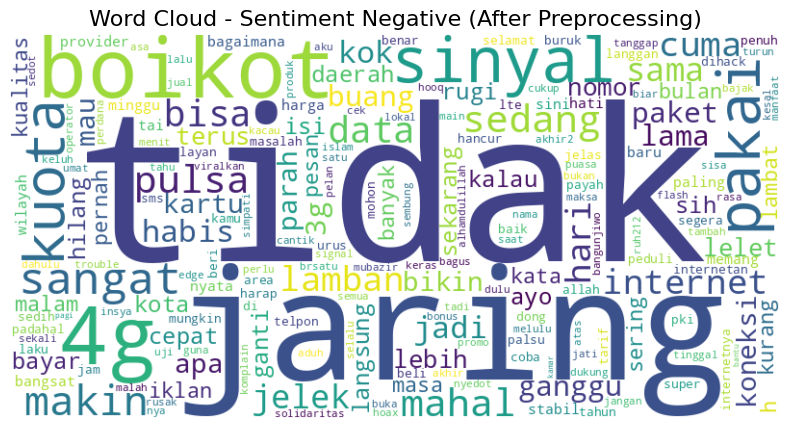

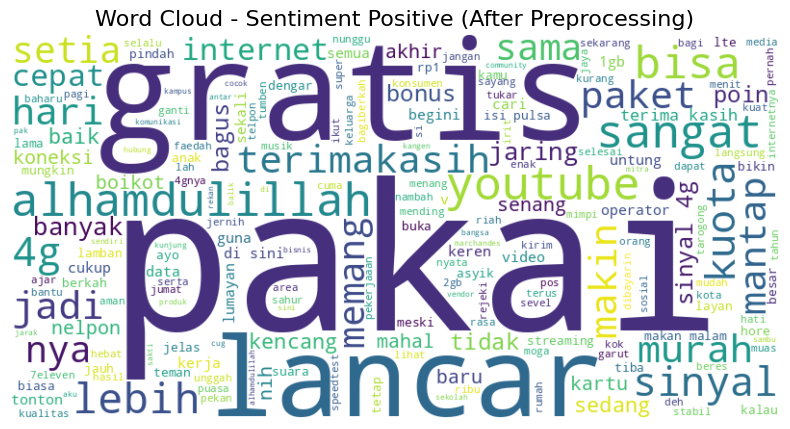

In [30]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# WordCloud untuk sentimen negatif
negatif_text = dataset[dataset["Sentiment"] == 'negative']["text_clean"]
text_negatif_joined = " ".join(negatif_text)
wordcloud_negatif = WordCloud(width=800, height=400, background_color='white').generate(text_negatif_joined)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negatif, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Sentiment Negative (After Preprocessing)", fontsize=16)
plt.show()

# WordCloud untuk sentimen positif
positif_text = dataset[dataset["Sentiment"] == 'positive']["text_clean"]
text_positif_joined = " ".join(positif_text)
wordcloud_positif = WordCloud(width=800, height=400, background_color='white').generate(text_positif_joined)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positif, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Sentiment Positive (After Preprocessing)", fontsize=16)
plt.show()

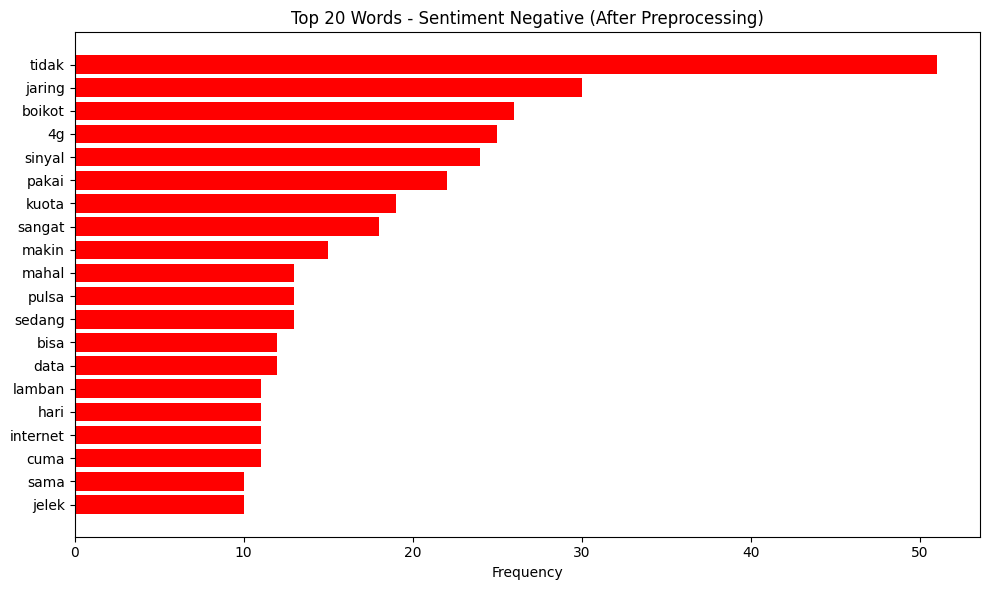

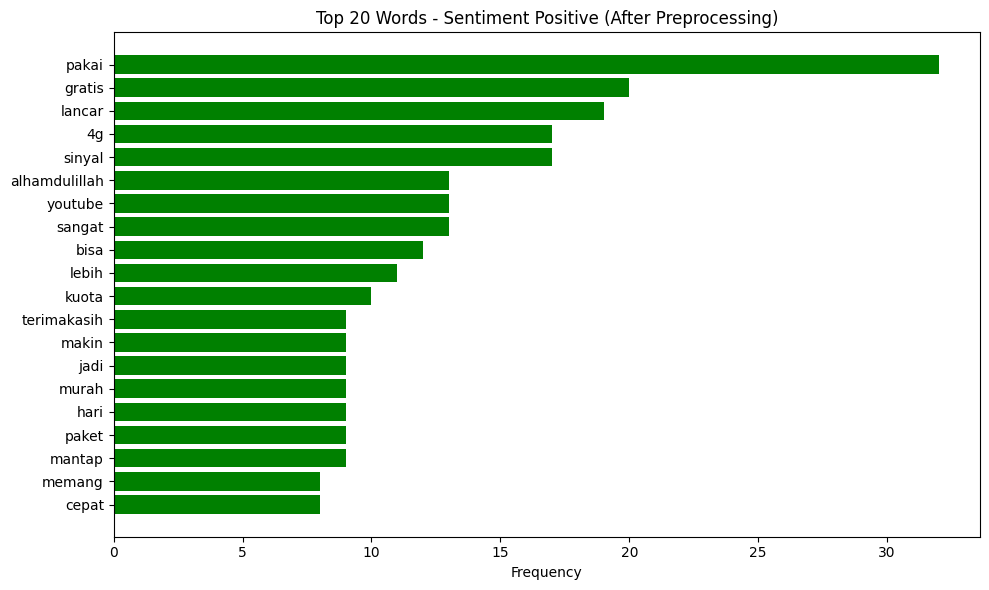

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import matplotlib.pyplot as plt

# Fungsi untuk plot bar kata teratas
def plot_top_words(text_series, title, color='skyblue'):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(text_series)
    word_counts = X.sum(axis=0).A1
    vocab = vectorizer.get_feature_names_out()
    
    freq_df = pd.DataFrame({'word': vocab, 'count': word_counts})
    top_words = freq_df.sort_values(by='count', ascending=False).head(20)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(top_words['word'][::-1], top_words['count'][::-1], color=color)
    plt.xlabel("Frequency")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Plot untuk sentimen negatif
negatif_text = dataset[dataset["Sentiment"] == 'negative']["text_clean"]
plot_top_words(negatif_text, "Top 20 Words - Sentiment Negative (After Preprocessing)", color='red')

# Plot untuk sentimen positif
positif_text = dataset[dataset["Sentiment"] == 'positive']["text_clean"]
plot_top_words(positif_text, "Top 20 Words - Sentiment Positive (After Preprocessing)", color='green')


Berdasarkan hasil visualasi frekuensi kata, setelah dilakukan cleansing pada "Text Tweet" didapatkan:

- `Sentiment Negative `

    Kata teratas yang paling sering muncul adalah jenis kata negasi (tidak, jelek, lamban, boikot), kata ungkapan (makin, sangat) serta terdapat entitas yang merepresentasikan konteks dari dataset yang sering dikeluhkan oleh pengguna provider yaitu terkait dengan jaring (kata dasar: jaringan), 4g, kuota, mahal, sinyal, internet.

- `Sentiment Positive`

    Pada sentiment positive kata yang sering muncul adalah kata ungkapan baik seperti (Alhamdulillah, mantap, lancar, terimakasih) serta terdapat kata yang mewakiliki konteks dari dataset yang sering menjadi bahan pujian kepada provider yaitu (sinyal, 4g, kuota, gratis,murah, cepat)

Bisa dikatakan hasil preprocessing sudah siap dilakukan proses training.

# Label Encoding

In [32]:
#Label Encoder untuk Mengganti Nilai Kategorik menjadi Numerik pada Variabel Target (Sentiment)
encoder = LabelEncoder()
dataset['Sentiment'] = encoder.fit_transform(dataset['Sentiment'])

label_enc_df = pd.DataFrame({'Sentiment': encoder.classes_, 'Nilai Numerik': encoder.transform(encoder.classes_)})
label_enc_df

,Sentiment,Nilai Numerik
0,negative,0
1,positive,1


Label encoding dilakukan untuk mengubah nilai kategorik pada data label "Sentiment" menjadi representasi Numerik untuk memudahkan pada proses training model. Kelas Sentiment Positive akan diwakili oleh nilai numerik `1` dan Kelas Sentiment Negative akan diwakili oleh nilai numerik `0`.

# Feature Extraction (TF-IDF)

TF-IDF atau "Term Frequency-Inverse Document Frequency" adalah metode statistik yang digunakan dalam pemrosesan teks untuk menilai seberapa penting sebuah kata (term) dalam suatu dokumen dalam kumpulan dokumen (korpus). Metode ini memberikan skor numerik kepada setiap kata berdasarkan seberapa sering kata tersebut muncul dalam dokumen tertentu dan seberapa unik kata tersebut dalam seluruh korpus.

In [33]:
# Inisialisasi fitur data (X), label data (y)
X = dataset['text_clean'] 
y = dataset['Sentiment']
 
# Ekstraksi fitur dengan TF-IDF
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X)
 
# Konversi hasil ekstraksi fitur menjadi dataframe
features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())
 
# Menampilkan hasil ekstraksi fitur
features_df

,000,100,1000,10ribu,12,12gb,1500,150mbps,1berbagi,1gb,1video,20,2007,2018,2100,22,23,25ribu,2g,2gb,30,300,30mb,30menit,36604,3g,3gb,3kbps,3minggu,4g,4glte,4gnya,5g,5gb,60,6gb,7eleven,9giga,acara,aceh,ada,adhan,aduh,ajaib,ajar,akhir,akhir2,akses,aksi,aktif,aktivitas,aku,alhamdulilah,alhamdulillah,allah,aman,ampun,an,anak,and,andal,anjing,antar,antek2nya,apa,aplikasi,arae,area,arit,arti,artikel,asa,astaga,asyik,atas,atau,ayo,baca,bagai,bagaimana,bagi,bagiberkah,bagus,bahan,baharu,bahkan,baik,bain,bajak,baju,balik,bandung,bangsa,bangsat,bangun,bangunjiwo,bantu,bantul,banyak,bareng,baru,batas,baterai,bawa,bayar,bbm,beda,begini,bekas,bela,belah,belanja,beli,benar,benci,bentuk,berbagiberkah,beres,beri,berita,berkah,berkat,besar,betah,biar,biasa,bicara,bijak,bikin,bilang,bilboard,biru,bisa,bisnis,bodoh,bogor,boikot,bonus,browsing,brsatu,buang,buat,buka,bukan,bukti,bulan,bunyi,buruk,busuk,cacat,camat,canggih,cantik,capture,cari,cek,ceo,cepat,ciamis,cie,cimahi,cisewu,ciwidey,coba,cocok,combo,community,counter,cs,cuaca,cug,cukup,cuma,curi,customer,daerah,daftarin,dahulu,dapat,daring,darurat,data,datang,deal,dear,deh,dengar,depan,detik,di,dibayarin,digangguin,diginikan,dihack,dikerjain,dipalembang,direspon,dong,dukung,dulu,dusta,edge,edit,emosi,enak,extra,facebook,faedah,fantastis,fasilitas,fast,festival,file,fitur,flash,free,full,fungsi,gabung,gajayana,gambar,game,ganggu,ganti,garut,gede,gemas,gendang,genflix,gera,gila,gin,google,got,gprs,gratis,greget,gsm,gua,gudang,guna,habis,hacker,hadiah,halimun,hancur,handphone,hapus,harap,harga,hari,harus,hashtag,hasil,hati,hebat,hemat,henti,hidup,hijrah,hilang,hoax,hobi,home,hooq,hore,hp,hrs,hubung,hujan,ide,iklan,ikut,indonesia,informasi,ingat,insya,internet,internetan,internetku,internetlelet,internetnya,intropeksi,irit,isi,islam,isya,itu,j5,jabo,jadi,jadimurahan,jagakarsa,jakarta,jam,jamin,jancok,jangan,jangkau,janji,jarak,jariangan,jarigan,jaring,jati,jauh,jawab,jaya,jd,jelas,jelek,jengkel,jernih,jogja,js,jual,juara,jumat,jumlah,kabupaten,kacau,kadang,kalau,kalian,kam,kamar,kampret,kampus,kamu,kamus,kangen,kapan,kartu,kasih,kasihan,kata,kaya,kb,kecepatanya,kecewa,kecil,kelar,kelas,keluarga,keluh,kencang,kensinya,keramat,keras,keren,kerja,kesal,kesini,kilobyte,kini,kira,kirim,klasik,klinikkumsda,kok,koko,komplain,komunikasi,konek,koneksi,konfirmasi,konsumen,kota,kotak,kotor,kouta,kramat,ku,kualitas,kuat,kuning,kunjung,kuota,kuotaaman,kuotagratis,kurang,lagipula,lagu,lah,laku,lalu,lama,lamban,lambat,lancar,lancar2,langgan,langsung,lanjut,lantun,lapak,lapor,lari2,layan,lebaran,lebih,lelet,lemah,lengkap,lho,libur,lihat,live,logika,lokal,lokasi,lombok,lte,luar,luas,lumayan,lupa,maaf,macam,madinah,mahal,mahasiswa,main,maju,makan,makanya,makin,maksa,malah,malam,malang,malas,mampir,mampus,mamuju,manfaat,mantap,mantapjiwa,marchandes,masa,masalah,masif,masuk,masyarakat,mata,mau,medan,media,mekah,melulu,memang,memggunakan,menang,mending,menit,mentari,meski,mimpi,minggu,minimal,minta,miskin,mitra,modal,moga,mohon,morowali,mu,muara,muas,mubazir,mudah,mudik,mulai,mumpung,mundur,mungkin,murah,musik,musuh,nabire,naik,nama,nambah,negara,nelepon,nelpon,network,ngabuburit,ngakses,ngecek,ngopi,nguras,nih,nikmat,nikmatin,noh,nomernya,nomor,normal,nulis,nunggu,nya,nyaman,nyata,nyedot,nyoba,obrol,off,oke,on,onlyforu,open,opensignal,operator,opinipenjualpulsa,orang,pada,padahal,page,pagi,paham,pak,pakai,paket,paket2,paling,palsu,palu,pandeglang,pandeglangkota,panggil,pantas,pantau,parah,passengers,payah,peduli,pejet2,pekan,pekerjaaan,pelan,pengin,penguna,penting,penuh,per,perdana,perhapean,perlu,pernah,pesan,pikir,pindah,ping,pki,poin,pointastic,pointasticdeal,pos,posko,prihatin,prinsip,produk,program,promo,promo2nya,promonya,protofon,provider,pt,puas,puasa,puaspake,publik,pulsa,puncak,purwakarta,pusing,ramadhan,ramai,rasa,rebah,referensi,rejeki,rekan,rekayasa,rekomendasi,rembang,reset,response,riah,ribu,rp1,rugi,ruh212,rumah,rupa,rupiah,rusak,saat,sahur,sakti,salah,sama,sambu,sambung,sampai,samsung,sana,sangat,san

In [34]:
#Save model TF-IDF
import joblib
joblib.dump(tfidf, 'TF-IDF.joblib')

['TF-IDF.joblib']

# Splitting Data

In [35]:
# Bagi data menjadi data training dan data testing
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.20, stratify=y, random_state=42)

# Total data
total_data = len(y)
train_count = len(y_train)
test_count = len(y_test)

# Persentase
train_pct = (train_count / total_data) * 100
test_pct = (test_count / total_data) * 100

print(f"Total data training : {train_count} data ({train_pct:.2f}%)")
print(f"Total data test   : {test_count} data ({test_pct:.2f}%)")

Total data training : 238 data (79.87%)
Total data test   : 60 data (20.13%)


# Modelling

Proses training model klasifikasi sentimen ini memiliki beberapa poin kunci penting, yaitu:

1. Model

    Supervised learning model yang digunakan adalah Support Vector Machine (SVM) dengan 2 percobaan yaitu training dengan dafault paramter dan optimisasi dengan metode `RandomizedSearchCV`.

2. Hyperparameter Tuning

    Model SVM akan dilakukan proses tuning parameter untuk memaksimalkan kinerja dari  model. Pada percobaan ini, dalam pencarian parameter yang terbaik akan menggunakan metode `RandomizedSearchCV`. dimana dalam proses pencarian kombinasi parameternya akan dilakukan secara acak, sesuai dengan range atau ruang parameter model yang didefinisikan sebelumnya. 
    
    Proses pencarian parameter akan dilakukan sesuai dengan jumlah iterasi (n_iter) yang ditentukan sebelumnya, dimana setiap kombinasi parameter akan terus dievaluasi menggunakan teknik `cross-validation (cv)` sehingga keakuratan model akan terjaga pada setiap iterasinya.

    Sebagai contoh `n_iter=50` dan `cv=5`, maka:

        - 50 kombinasi parameter yang akan dicoba
        - Masing-masing kombinasi akan diuji dengan 5 kali cross-validation

    Total model yang dilatih: 50 × 5 = 250 kali fitting

    Teknik ini lebih efisien dari `GridSearchCV` (yang mencoba semua kombinasi secara eksplisit).

3. Evaluasi Model

    Berikut metrik evaluasi yang akan digunakan:

        - Accuracy, menggambarkan seberapa sering model membuat prediksi yang benar.
        - Precision, menggambarkan seberapa baik model mengidentifikasi kelas positif.
        - Recall, menggambarkan seberapa baik model mengidentifikasi semua kelas positif yang sebenarnya.
        - F1-Score, metrik yang menggabungkan presisi dan recall menjadi satu skor tunggal.
        - ROC AUC, mengukur kinerja model dalam mengklasifikasikan kelas positive dan negative.
        - Confusion Matrix, Visualisai matriks 2x2 yang menunjukkan True Positive, False Positive, True Negative, False Negative

**Support Vector Machines (SVM)** merupakan algoritma klasifikasi yang kuat dan fleksibel, yang bekerja dengan mencari hyperplane terbaik yang memisahkan data menjadi dua kelas atau lebih. SVM mencari hyperplane yang memaksimalkan margin antara kelas. Margin didefinisikan sebagai jarak terkecil antara hyperplane dan titik-titik data terdekat dari kedua kelas. Titik-titik data ini disebut support vectors.

## Default Parameter

Training Accuracy SVM (Default Parameter) : 1.0
Testing Accuracy SVM  (Default Parameter) : 0.9166666666666666
Precision SVM (Default Parameter)         : 0.96
Recall SVM (Default Parameter)            : 0.8571428571428571
F1-score SVM  (Default Parameter)         : 0.9056603773584906
ROC AUC Score SVM (Default Parameter)     : 0.9720982142857143

Classification Report - SVM (Binary Sentiment Classification):
              precision    recall  f1-score   support

    negative       0.89      0.97      0.93        32
    positive       0.96      0.86      0.91        28

    accuracy                           0.92        60
   macro avg       0.92      0.91      0.92        60
weighted avg       0.92      0.92      0.92        60



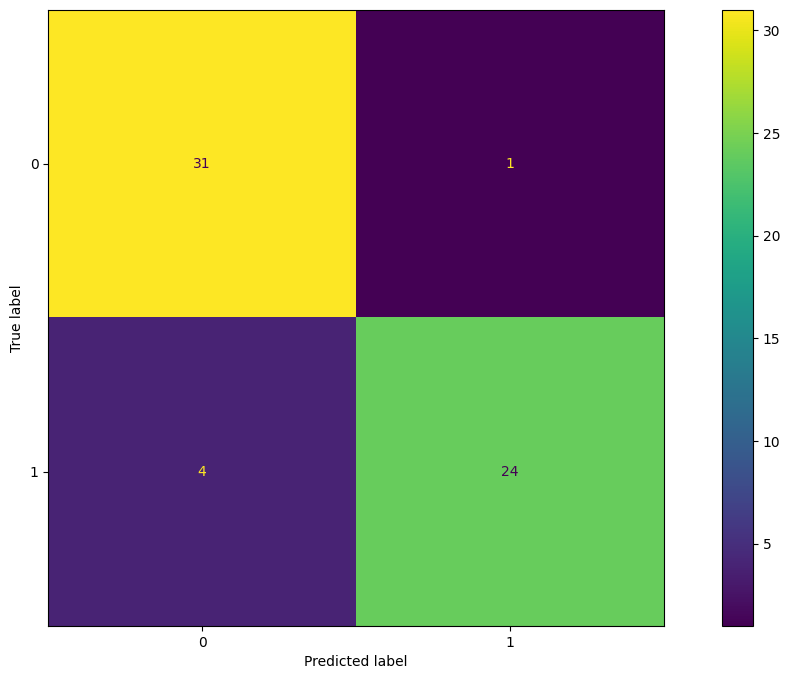

In [36]:
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    ConfusionMatrixDisplay,
    classification_report
)

# Inisialisasi model SVM dengan default parameter
svm = SVC(probability=True, random_state=42)

# Latih model
svm.fit(X_train.toarray(), y_train)

# Prediksi
y_train_pred_svm = svm.predict(X_train.toarray())
y_test_pred_svm = svm.predict(X_test.toarray())

# Evaluasi metrik
Train_Accuracy_SVM = accuracy_score(y_train, y_train_pred_svm)
Test_Accuracy_SVM = accuracy_score(y_test, y_test_pred_svm)
Precision_SVM = precision_score(y_test, y_test_pred_svm, average='binary', pos_label=1)
Recall_SVM = recall_score(y_test, y_test_pred_svm, average='binary', pos_label=1)
F1score_SVM = f1_score(y_test, y_test_pred_svm, average='binary', pos_label=1)

print(f"Training Accuracy SVM (Default Parameter) : {Train_Accuracy_SVM}")
print(f"Testing Accuracy SVM  (Default Parameter) : {Test_Accuracy_SVM}")
print(f"Precision SVM (Default Parameter)         : {Precision_SVM}")
print(f"Recall SVM (Default Parameter)            : {Recall_SVM}")
print(f"F1-score SVM  (Default Parameter)         : {F1score_SVM}")

# ROC AUC Score
y_test_prob_svm = svm.predict_proba(X_test.toarray())[:, 1]
roc_auc_svm = roc_auc_score(y_test, y_test_prob_svm)
print(f"ROC AUC Score SVM (Default Parameter)     : {roc_auc_svm}")

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(svm, X_test.toarray(), y_test)

# Classification Report
print("\nClassification Report - SVM (Binary Sentiment Classification):")
print(classification_report(y_test, y_test_pred_svm, target_names=["negative", "positive"]))


In [37]:
# Save Model
import joblib

joblib.dump(svm, "svm-sentiment-model-default.joblib")

['svm-sentiment-model-default.joblib']

## Optimization with RandomizedSearchCV

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters (SVM): {'C': np.float64(0.9837555188414592), 'kernel': 'linear'}
Training Accuracy_SVM_RandomizedSearchCV : 0.9831932773109243
Testing Accuracy_SVM_RandomizedSearchCV  : 0.9166666666666666
Precision_SVM_RandomizedSearchCV         : 0.896551724137931
Recall_SVM_RandomizedSearchCV            : 0.9285714285714286
F1-score_SVM_RandomizedSearchCV          : 0.9122807017543859
ROC AUC Score_SVM_RandomizedSearchCV     : 0.9698660714285714

Classification Report - SVM (Binary Sentiment Classification):
              precision    recall  f1-score   support

    negative       0.94      0.91      0.92        32
    positive       0.90      0.93      0.91        28

    accuracy                           0.92        60
   macro avg       0.92      0.92      0.92        60
weighted avg       0.92      0.92      0.92        60



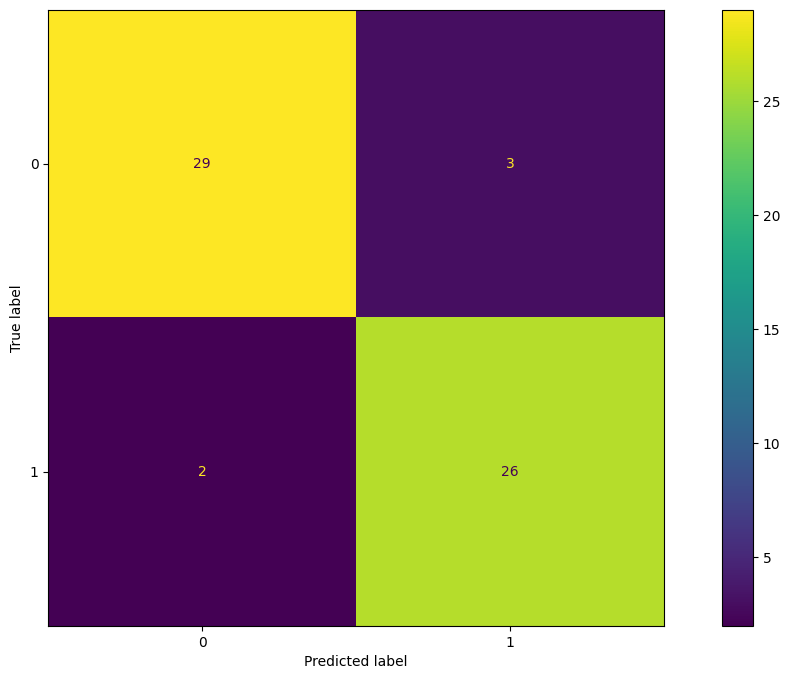

In [38]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    ConfusionMatrixDisplay,
    classification_report
)
from scipy.stats import uniform

# Inisialisasi model SVM
svm = SVC(probability=True, random_state=42)

# Tuning parameter untuk SVM
param_rsp_SVM = {
    'C': uniform(0.01, 1),              # Parameter regularisasi (penalti terhadap kesalahan).
    'kernel': ['linear', 'rbf']         # mengubah data input ke dimensi yang lebih tinggi agar lebih mudah dipisahkan secara linear.
}

# RandomizedSearchCV
random_search_SVM = RandomizedSearchCV(
    estimator=svm,
    param_distributions=param_rsp_SVM,
    n_iter=30,
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Latih model
random_search_SVM.fit(X_train.toarray(), y_train)

# Prediksi
y_train_pred_svm = random_search_SVM.predict(X_train.toarray())
y_test_pred_svm = random_search_SVM.predict(X_test.toarray())

# Evaluasi metrik
print("Best Parameters (SVM):", random_search_SVM.best_params_)

Train_Accuracy_SVM = accuracy_score(y_train, y_train_pred_svm)
Test_Accuracy_SVM = accuracy_score(y_test, y_test_pred_svm)
Precision_SVM = precision_score(y_test, y_test_pred_svm, average='binary', pos_label=1)
Recall_SVM = recall_score(y_test, y_test_pred_svm, average='binary', pos_label=1)
F1score_SVM = f1_score(y_test, y_test_pred_svm, average='binary', pos_label=1)

print(f"Training Accuracy_SVM_RandomizedSearchCV : {Train_Accuracy_SVM}")
print(f"Testing Accuracy_SVM_RandomizedSearchCV  : {Test_Accuracy_SVM}")
print(f"Precision_SVM_RandomizedSearchCV         : {Precision_SVM}")
print(f"Recall_SVM_RandomizedSearchCV            : {Recall_SVM}")
print(f"F1-score_SVM_RandomizedSearchCV          : {F1score_SVM}")

# ROC AUC Score
y_test_prob_svm = random_search_SVM.predict_proba(X_test.toarray())[:, 1]
roc_auc_svm = roc_auc_score(y_test, y_test_prob_svm)
print(f"ROC AUC Score_SVM_RandomizedSearchCV     : {roc_auc_svm}")

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(random_search_SVM, X_test.toarray(), y_test)

# Classification Report
print("\nClassification Report - SVM (Binary Sentiment Classification):")
print(classification_report(y_test, y_test_pred_svm, target_names=["negative", "positive"]))


In [39]:
# Save Model
import joblib

joblib.dump(random_search_SVM, "svm-sentiment-model-optimized.joblib")

['svm-sentiment-model-optimized.joblib']